# Stock Market Predictions - LSTM Neural Networks

###### Ignacio Antequera Sanchez

# 0. Introduction
---

Hello Everyone! 

Welcome to my Stock Market Predictions Project using ```LSTM Neural Networks```. My name is Ignacio Antequera and in this notebook, I will be sharing with you how we can use a time-series model known as Long Short-Term Memory.

The logic behind this project is to use machine learning models that can look at the history of a sequence of data and correctly predict what the future elements of the sequence are going to be. This is where ```time series modeling``` comes in.

> Disclaimer: This project is solely for learning purposes and does not serve as a financial advisor. Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly.

The objective of this project id to see if we can model the data, so that the predictions we make correlate with the actual behavior of the data. In other words, we don't need the exact stock values of the future, but the stock price movements

### Import Libraries:

In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

# 1. Downloading the data
---

If you are interestee in working with up-to-date data, you can get that Data from Alphavantage. However, you can also download static data directly from [Kaggle](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs). This is a huge stock market dataset that contains   Historical daily prices and volumes of all U.S. stocks and ETFs. For the purposes of this demo, I will be using this option. However, you may access other demos on this repository where I will be analyzing stocks whose data has been retrieved from Alphavantage. Note that if we select this option, you will need to copy the Stocks folder in the zip file to your project home folder.

- Since we going to make use of the American Airlines Stock market prices to make your predictions, we set the ticker to `"AAL"`. 
- We define a `url_string`, which will return a JSON file with all the stock market data for American Airlines within the last 20 years.
- We define a `file_to_save`, which will be the file to which we save the data. 
- We will use the `ticker` variable that we defined beforehand to help name this file.
- Next, we are going to specify a condition: if you haven't already saved data.
- We will go ahead and grab the data from the URL that we set in `url_string`
- We'll store the date, low, high, volume, close, open values to a pandas DataFrame df. 
- We will save it to file_to_save. However, if the data is already there, we'll just load it from the CSV. (This is useful for future runs of the code)

In [2]:
# Select the method that best suits you.
data_source = 'Kaggle'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7F6B6RZW9SPFQE8N'

    # Apple stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # Grab the data from the url
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            # Store date, low, high, volume, close, open values to a Pandas DataFrame
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','amzn.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


# 2. Data Exploration
---

Now that we have our data properly stored, let's take a quick look at its structure. But first, since we are going to be working on time series modelling, we need to make sure that the data is sorted by date.

In [3]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,1997-05-16,1.97,1.98,1.71,1.73
1,1997-05-19,1.76,1.77,1.62,1.71
2,1997-05-20,1.73,1.75,1.64,1.64
3,1997-05-21,1.64,1.65,1.38,1.43
4,1997-05-22,1.44,1.45,1.31,1.40


# 3. Data Visualization
---

Now, let's take a look at what sort of data we have. We are interested in data with various patterns occurring over time.

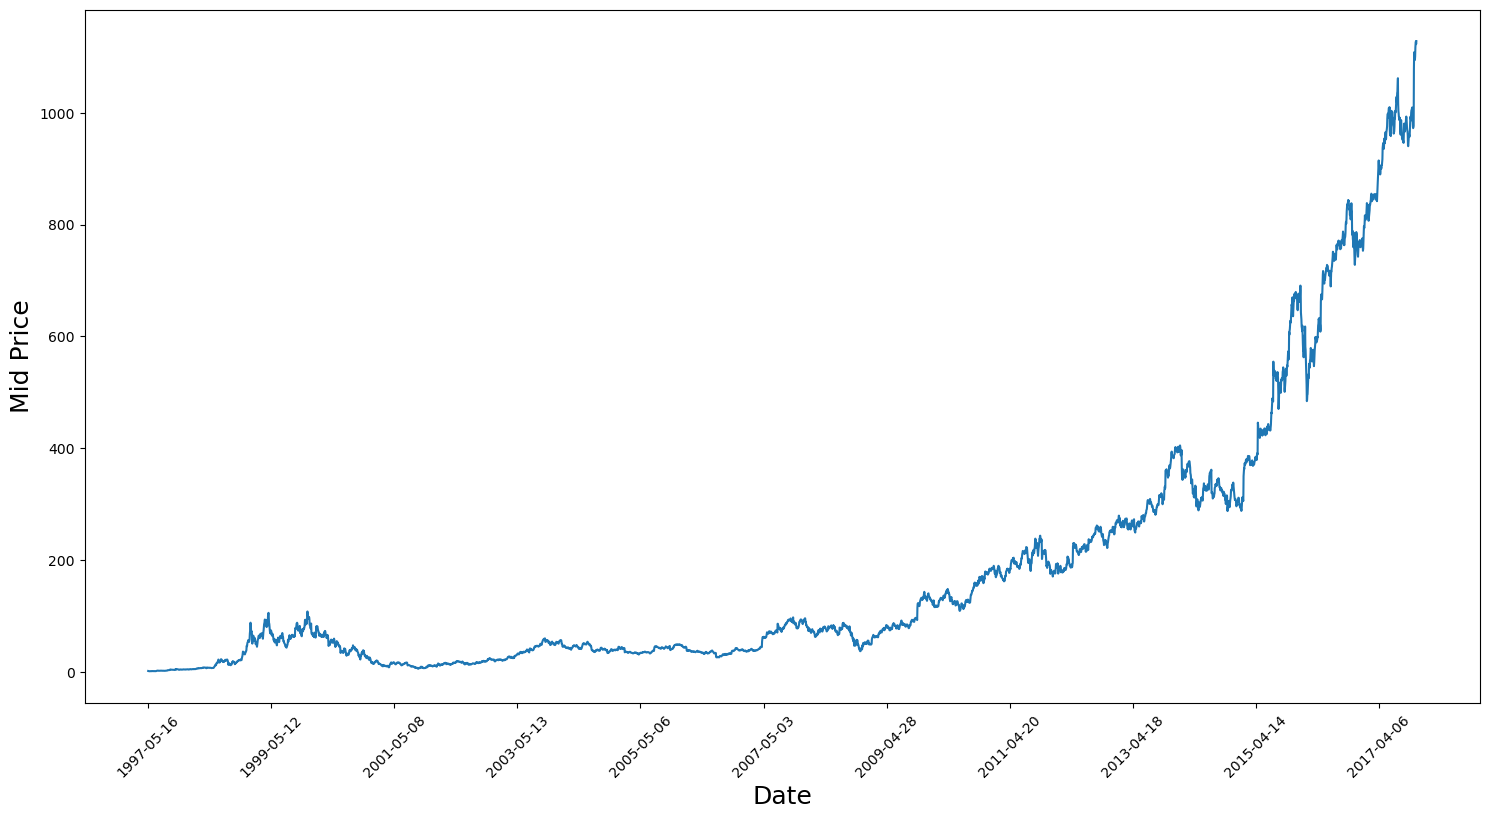

In [4]:
# Set the size of the figure
plt.figure(figsize = (18,9))

# Create the line plot
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)

# Set the x-axis tick marks to be every 500 rows in df
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)

# Set the x-axis and y-axis labels
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

# Display the plot
plt.show()

This graph provides valuable insights into various aspects. The reason we chose this particular company over others is due to the diverse range of behaviors exhibited by its stock prices over time, making it an excellent candidate for robust learning and providing ample opportunities to evaluate prediction accuracy across different scenarios.

It's worth noting that the stock prices around 2017 exhibit significantly higher values and greater fluctuations compared to those around the 1970s. Therefore, it's essential to ensure consistent value ranges for the data throughout the entire time frame. This normalization process will be addressed during the data normalization phase.